Note: Train this notebook on GPU.

Download the already preprocessed 50000 CelebA images in npz form here.

https://aistudio.baidu.com/aistudio/datasetdetail/127327 

In [1]:
import numpy as np
import paddle 
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [3]:
samples = np.load('data/data127327/imgs 000001 to 050000.npz')['arr_0']
print(samples.shape, samples.dtype)

(50000, 80, 80, 3) uint8


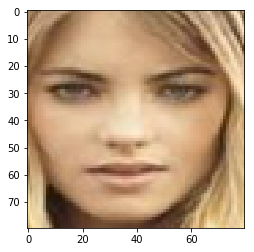

In [65]:
# see an example
plt.imshow(samples[18])
plt.show()

In [5]:
# random obtain some samples and map each pixel to [-1,1]
def generate_samples(n=80):
    # Turn channel afront [N, H, W, C] -> [N, C, W, H]
    samples_batch = np.transpose(samples[np.random.randint(0,samples.shape[0],size=(n,))], (0,3,1,2))
    return samples_batch.astype('float') / 127.5 - 1.

In [2]:
latent_dim = 100

discriminator = paddle.nn.Sequential(
    paddle.nn.Conv2D(3,64,(5,5),padding=1),
    paddle.nn.LeakyReLU(0.2),
    paddle.nn.Conv2D(64,64,(5,5),stride=(2,2),padding=1),
    paddle.nn.LeakyReLU(0.2),
    paddle.nn.Conv2D(64,64,(5,5),stride=(2,2),padding=1),
    paddle.nn.LeakyReLU(0.2),    
    paddle.nn.Conv2D(64,64,(5,5),stride=(2,2),padding=1),
    paddle.nn.LeakyReLU(0.2), 
    paddle.nn.Conv2D(64,64,(5,5),stride=(2,2),padding=1),
    paddle.nn.LeakyReLU(0.2),
    paddle.nn.Flatten(),
    paddle.nn.Dropout(0.4),
    paddle.nn.Linear(576,2),
    # softmax to obtain probability, 0 for predicting fake while 1 for real
    paddle.nn.Softmax()
)

generator = paddle.nn.Sequential(
    # input: (batch_size, latent_dim, 1, 1)
    paddle.nn.Conv2DTranspose(latent_dim,128,(5,5)),
    paddle.nn.LeakyReLU(),
    # upsample
    paddle.nn.Conv2DTranspose(128,128,(4,4),stride=(2,2),padding=1,bias_attr=False),
    paddle.nn.LeakyReLU(),
    # upsample
    paddle.nn.Conv2DTranspose(128,128,(4,4),stride=(2,2),padding=1,bias_attr=False),
    paddle.nn.LeakyReLU(),
    # upsample
    paddle.nn.Conv2DTranspose(128,128,(4,4),stride=(2,2),padding=0,bias_attr=False),
    paddle.nn.LeakyReLU(),
    # upsample
    paddle.nn.Conv2DTranspose(128,128,(4,4),stride=(2,2),padding=1,bias_attr=False),
    paddle.nn.LeakyReLU(),
    paddle.nn.Conv2D(128,3,(5,5)),
    # tanh -> [-1,1]
    paddle.nn.Tanh()
)

optimizer_dis = paddle.optimizer.Adam(parameters=discriminator.parameters(), learning_rate=2e-4, beta1=0.5)
optimizer_gen = paddle.optimizer.Adam(parameters=generator.parameters(), learning_rate=2e-4, beta1=0.5)
losses_dis = []
losses_gen = []

C:\Users\forever豪3\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# check the generator output size
latent_seeds = paddle.randn((10, latent_dim, 1, 1))
generator(latent_seeds).shape

[10, 3, 80, 80]

In [46]:
epochs = 15000
batch_size = 128
for epoch in tqdm(range(1+len(losses_dis), 1+len(losses_dis)+epochs)):
    # discriminator
    samples_real = paddle.to_tensor( generate_samples(batch_size // 2) , dtype=paddle.get_default_dtype())

    latent_seeds = paddle.randn((batch_size // 2, latent_dim,1,1))
    samples_fake = generator(latent_seeds)

    predicts_real = discriminator(samples_real)
    predicts_fake = discriminator(samples_fake)

    loss  = -paddle.mean(paddle.log(predicts_real[:,1]))
    loss -= paddle.mean(paddle.log(predicts_fake[:,0]))
    losses_dis.append(loss.item()) 

    optimizer_dis.clear_grad()
    loss.backward()
    optimizer_dis.step()
    
    # generator
    latent_seeds = paddle.randn((batch_size // 2, latent_dim,1,1))
    samples_fake = generator(latent_seeds)

    predicts_fake = discriminator(samples_fake)

    loss  = -paddle.mean(paddle.log(predicts_fake[:,1]))
    losses_gen.append(loss.item()) 

    optimizer_gen.clear_grad()
    loss.backward()
    optimizer_gen.step()

    # save 
    if epoch % 2000 == 0:
        obj = {'model': discriminator.state_dict(), 'opt': optimizer_dis.state_dict(), 'epoch': len(losses_dis)}
        paddle.save(obj, f'work/dis {epoch}.pdparams')
        obj = {'model': generator.state_dict(), 'opt': optimizer_gen.state_dict(), 'epoch': len(losses_gen)}
        paddle.save(obj, f'work/gen {epoch}.pdparams')
        losses = np.array([losses_dis,losses_gen])
        np.savez_compressed(f'work/loss.npz',losses)

100%|██████████| 15000/15000 [29:27<00:00,  8.51it/s]


Hint: Do not start with thousands of epochs. Start small (e.g. epochs=300) and check whether the loss rockets up to Nan. If it has overflowed, please restart the training.

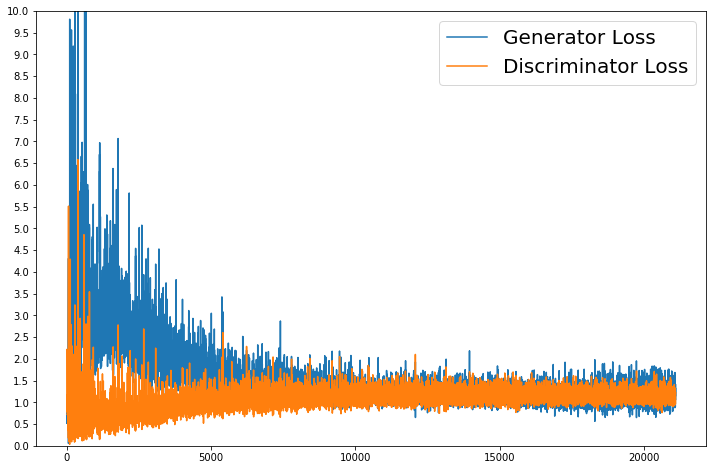

In [56]:
plt.figure(figsize=(12,8))
plt.plot(losses_gen)
plt.plot(losses_dis)
plt.ylim(0,10)
plt.yticks(np.linspace(0,10,21))
plt.legend(['Generator Loss','Discriminator Loss'],fontsize=20)
plt.show()

In [69]:
def validate(generator,discriminator,batch_size):
    samples_real = paddle.to_tensor( generate_samples(batch_size) ,dtype='float32' )

    latent_seeds = paddle.randn((batch_size, latent_dim, 1, 1))
    samples_fake = generator(latent_seeds)

    predicts_real = discriminator(samples_real).numpy()
    predicts_fake = discriminator(samples_fake).numpy()

    acc_real = np.sum(np.argmax(predicts_real, axis=-1)) / batch_size
    acc_fake = 1. - np.sum(np.argmax(predicts_fake, axis=-1)) / batch_size
    return acc_real, acc_fake

acc_real, acc_fake = validate(generator,discriminator,500)
print(f'Accuracy on realworld images = {acc_real*100}%')  
print(f'Accuracy on generated images = {acc_fake*100}%')     

Accuracy on realworld images = 59.199999999999996%
Accuracy on generated images = 77.60000000000001%


In [4]:
obj = paddle.load('DCGAN CelebA Models\\dis 20000.pdparams')
discriminator.set_state_dict(obj['model'])
obj = paddle.load('DCGAN CelebA Models\\gen 20000.pdparams')
generator.set_state_dict(obj['model'])

C:\Users\forever豪3\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


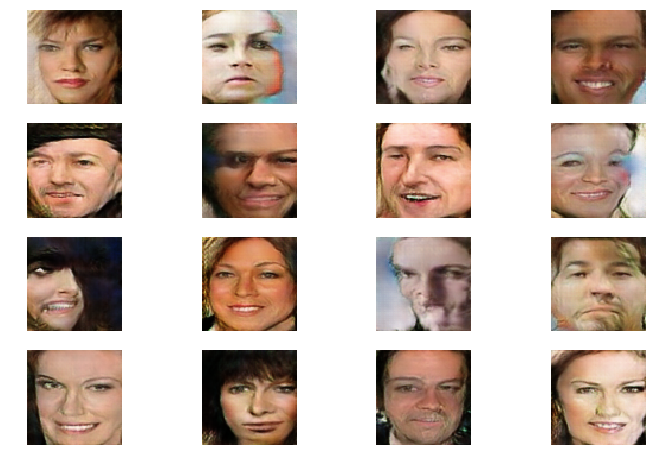

In [64]:
# check the performance (generated figures with 21100 epochs below)
display_row = 4
latent_seeds = paddle.randn((display_row**2, latent_dim, 1, 1))
samples_fake = generator(latent_seeds).numpy()
plt.figure(figsize=(12,8))
for i in range(display_row**2):
    plt.subplot(display_row,display_row,1+i)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[i]*0.5+0.5, (1,2,0)))
plt.show()

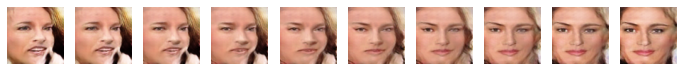

In [63]:
# explore the latent space
interpolate = 10
display_row = interpolate

latent_seeds_a = np.random.randn(latent_dim,1)
latent_seeds_b = np.random.randn(latent_dim,1)

# interpolate:   x = t(b - a) + a   , 0 <= t <= 1
latent_seeds = (latent_seeds_b - latent_seeds_a) @ np.linspace(0,1,interpolate).reshape((1,interpolate))
latent_seeds = (latent_seeds + latent_seeds_a).T.reshape((interpolate, latent_dim, 1, 1))
latent_seeds = paddle.to_tensor( latent_seeds[:display_row] ,dtype='float32')

samples_fake = generator(latent_seeds).numpy()
plt.figure(figsize=(12,8))
for i in range(display_row):
    plt.subplot(1,display_row,1+i)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[i]*0.5+0.5, (1,2,0)))
plt.show()

C:\Users\forever豪3\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


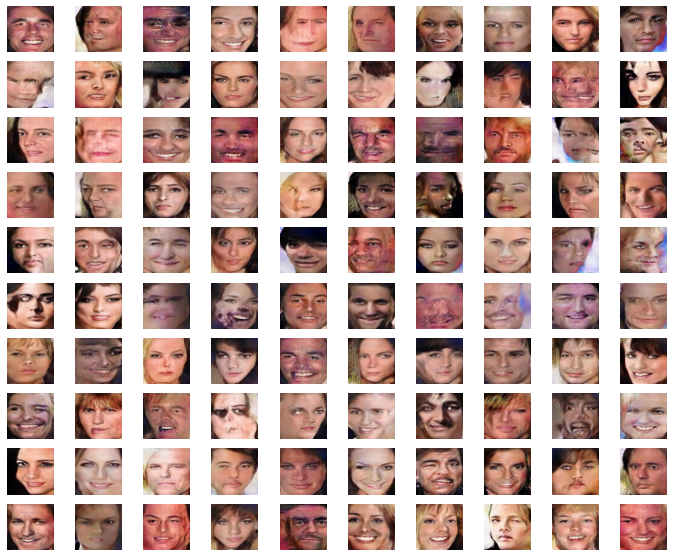

In [86]:
# manually find some faces -- seemingly smiling man, smiling woman and a neutral woman
display_row = 10
paddle.seed(0)
latent_seeds = paddle.randn((display_row**2, latent_dim, 1, 1))
samples_fake = generator(latent_seeds).numpy()
plt.figure(figsize=(12,10))
for i in range(display_row**2):
    plt.subplot(display_row,display_row,1+i)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[i]*0.5+0.5, (1,2,0)))
plt.show()

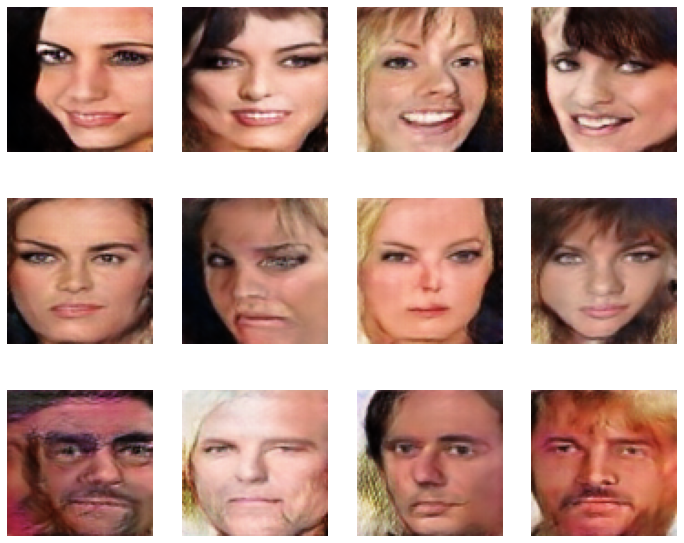

In [109]:
# manually take some (seemingly) smiling women, neutral women and neutral men:
display_row = 10
paddle.seed(0)
#latent_seeds = paddle.randn((display_row**2, latent_dim, 1, 1))
#samples_fake = generator(latent_seeds).numpy()

smiling_women = paddle.to_tensor([80,51,96,69])
neutral_women = paddle.to_tensor([13,38,62,93])
neutral_men   = paddle.to_tensor([94,82,89,27])
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(3,4,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[smiling_women[i].item()]*0.5+0.5, (1,2,0)))
    
    plt.subplot(3,4,i+5)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[neutral_women[i].item()]*0.5+0.5, (1,2,0)))
    
    plt.subplot(3,4,i+9)
    plt.axis('off')
    plt.imshow(np.transpose(samples_fake[neutral_men[i].item()]*0.5+0.5, (1,2,0)))
plt.show()

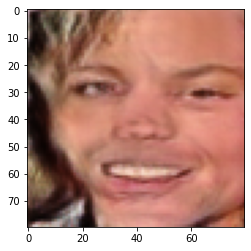

In [110]:
avg_smiling_women = paddle.mean(latent_seeds.gather(smiling_women), axis=0)
avg_neutral_women = paddle.mean(latent_seeds.gather(neutral_women), axis=0)
avg_neutral_men   = paddle.mean(latent_seeds.gather(neutral_men), axis=0)

avg_smiling_men = avg_smiling_women + avg_neutral_men - avg_neutral_women
avg_smiling_men = avg_smiling_men.reshape((1, latent_dim, 1, 1))
samples_smiling_men = generator(avg_smiling_men).numpy()[0]

# little bit weird, but not too bad
plt.imshow(np.transpose(samples_smiling_men*0.5+0.5, (1,2,0)))